In [1]:
## Notebook env: gedi (R kernel)
## GEDI pt.2 - runs GEDI to find spliced/unspliced ratio of genes across perturbations

## get the unspliced and spliced counts mtxs for each of miR_1, miR_2, miR_3
## combine all unspliced mtxs and alle spliced mtxs into two final mtxs (save with scanpy)
## read into R the two mtxs with scrattch.io::read_loom_dgCMatrix, input into gedi

## then take imputed psi values (spliced/unspliced counts -- RNA stability) from gedi model and make violin plots of them as drawn in RM2

In [2]:
.libPaths('/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

## install packages below into env if not already installed
## remotes::install_github('csglab/GEDI', lib = '/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

library(HDF5Array)
library(ggplot2)
library(Matrix)
library(RColorBrewer)
library(uwot)
library(GEDI)
library(SeuratWrappers)
set.seed(43)

Loading required package: DelayedArray

Loading required package: stats4



Loading required package: Matrix

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, 

In [3]:
## load loom files
miR_1 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/miR_1/miR_1.loom')
miR_2 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/miR_2/miR_2.loom')
miR_3 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/miR_3/miR_3.loom')

In [4]:
spliced = list(miR_1[['spliced']], miR_2[['spliced']], miR_3[['spliced']])
unspliced = list(miR_1[['unspliced']], miR_2[['unspliced']], miR_3[['unspliced']])

In [5]:
## combine spliced and unspliced counts into two final mtxs
## the gedi model will take sample labels within each of the two mtxs
spliced_combined = cbind(spliced[[1]], spliced[[2]], spliced[[3]])
unspliced_combined = cbind(unspliced[[1]], unspliced[[2]], unspliced[[3]])

## filter out genes with low median UMIs from the expression data
filtered_meta_data <- read.csv('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_meta.csv', header = TRUE)
rownames(filtered_meta_data) <- filtered_meta_data$X
filtered_meta_data$guide <- as.character(filtered_meta_data$guide)

raw_genes <- read.csv('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_gene_names.csv', header = FALSE)
raw_genes <- raw_genes$V2[-1]
raw_genes <- as.character(raw_genes)

filtered_raw_mtx <- readMM('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_data.mtx')
filtered_raw_mtx = as(filtered_raw_mtx, 'dgCMatrix')
rownames(filtered_raw_mtx) = raw_genes
colnames(filtered_raw_mtx) = rownames(filtered_meta_data)
medians = sparseMatrixStats::rowMedians(filtered_raw_mtx)
genes_to_keep = as.numeric(medians) >= 0.01
filtered_raw_mtx <- filtered_raw_mtx[genes_to_keep,]

spliced_combined = spliced_combined[rownames(filtered_raw_mtx)[rownames(filtered_raw_mtx) %in% rownames(spliced_combined)],]
unspliced_combined = unspliced_combined[rownames(filtered_raw_mtx)[rownames(filtered_raw_mtx) %in% rownames(unspliced_combined)],]

## filter out low splice/unspliced count cells and low count genes
filtered_cols <- which(log10(colSums(spliced_combined)) > 3 & log10(colSums(unspliced_combined)) > 3)
filtered_rows <- which(rowSums(spliced_combined) > 50 & rowSums(unspliced_combined) > 50)
spliced_combined = spliced_combined[filtered_rows, filtered_cols]
unspliced_combined = unspliced_combined[filtered_rows, filtered_cols]

## get sample identity
sample_identity = stringr::str_sub(colnames(spliced_combined), start = 1, end = 5)


'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [26]:
## percent of cells that remain after filtering
100*length(filtered_cols) / ncol(cbind(spliced[[1]], spliced[[2]], spliced[[3]]))

## percent of genes that remain after filtering
100*length(filtered_rows) / nrow(cbind(spliced[[1]], spliced[[2]], spliced[[3]]))

[1] 96.41238

[1] 17.93667

Warning message:
“Removed 11063 rows containing non-finite outside the scale range
(`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


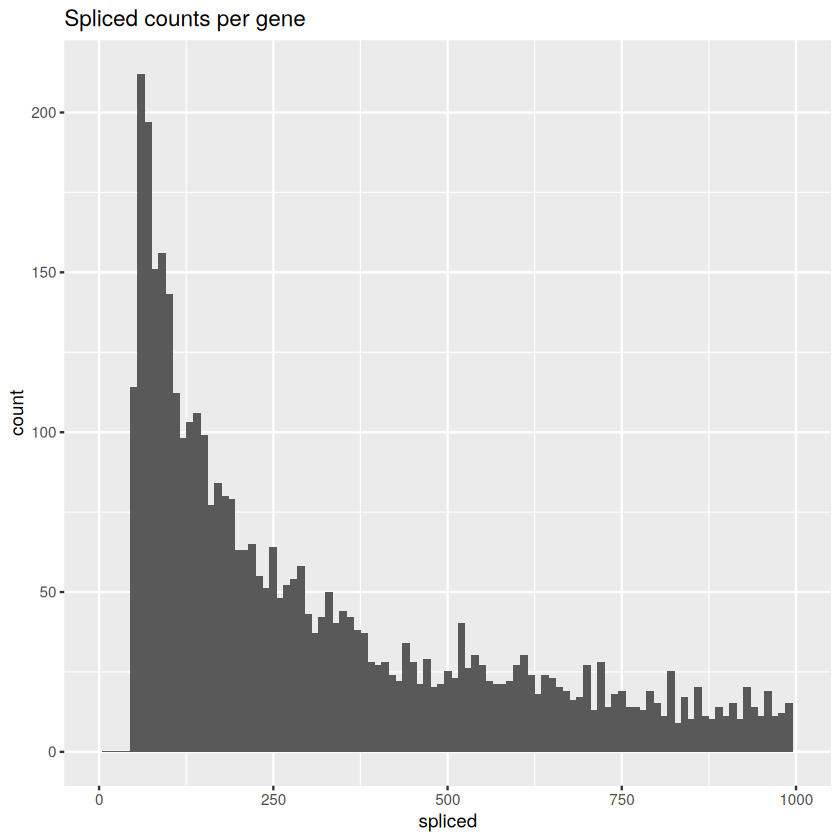

In [7]:
df = data.frame(spliced = rowSums(spliced_combined[rowSums(spliced_combined) > 50, colSums(spliced_combined) > 50]))
ggplot(df, aes(x = spliced)) + geom_histogram(binwidth = 10) + xlim(0, 1000) + ggtitle('Spliced counts per gene')

Warning message:
“Removed 42082 rows containing non-finite outside the scale range
(`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


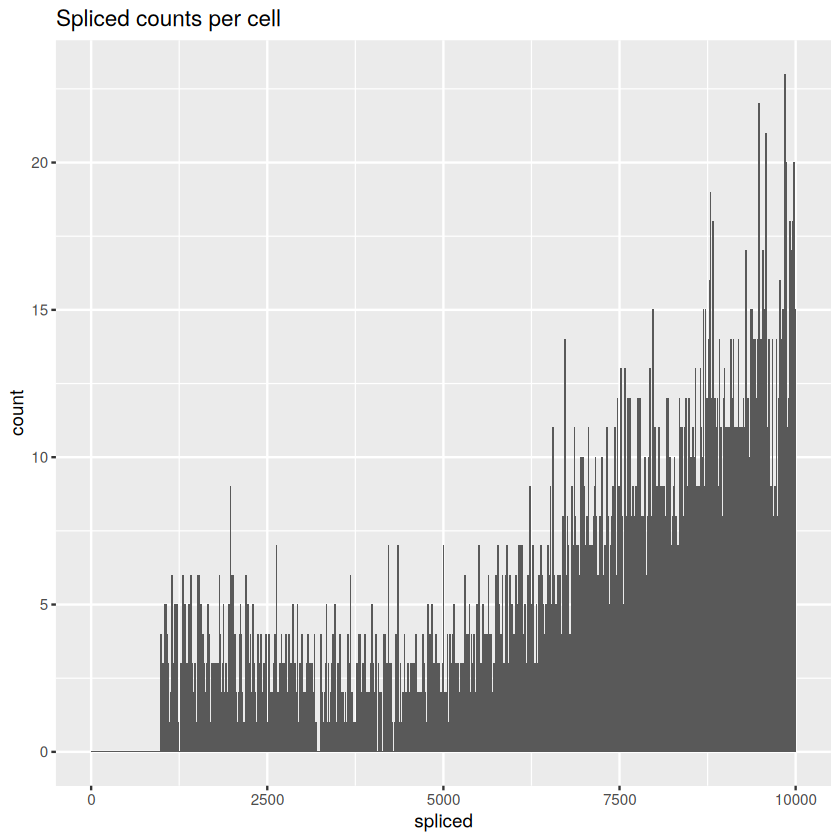

In [8]:
df2 = data.frame(spliced = colSums(spliced_combined[rowSums(spliced_combined) > 50, colSums(spliced_combined) > 50]))
ggplot(df2, aes(x = spliced)) + geom_histogram(binwidth = 10) + xlim(0, 10000) + ggtitle('Spliced counts per cell')

In [9]:
rm(miR_1, miR_2, miR_3, spliced, unspliced, filtered_cols, filtered_rows, df, df2, filtered_raw_mtx)

In [10]:
## Set up GEDI model
model <- new("GEDI") # Initialize GEDI object
model$setup(Samples = sample_identity, # Vector indicating which sample belongs to each cell
            colData = data.frame(cell_names = colnames(spliced_combined)), # Metadata (optional)
            M = list(spliced_combined, unspliced_combined), # Expression data as a list of two matrices, in which case they are considered as paired observations whose log-ratio must be modelled.
            K = 20, # Number of latent variables to use
            mode = "Bsphere", # Modes to use: Either Bsphere (hyperellipsoid) or Bl2 (hyperplane)
            oi_shrinkage = 0.001 # Shrinkage multiplier for oi. In here we use 0.001, to better accommodated the mean abundance differences that exist between multiple scRNA-seq technologies.
            ) 
model$initialize.LVs(randomSeed = 1) # initialize LVs
model$optimize(iterations = 150) # run model with 150 iterations
saveRDS(model, file = "/home/ssobti/projects/mir_tud/output_data/splicing/miR/miR_gedi_model.rds") # Saving output model

Setting up the GEDI model...



Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


Initializing LVs...



  Initializing oi...



  Performing initial decompsition of Y...



Performing block coordinate descent optimization...



  Iteration 1/150 (total 1)...



3.124183 
1 
Mean(o): -0.9943117 ; Var(o): 1.40228 ; Var(si): 0.002084286 


  Iteration 2/150 (total 2)...



2.853827 
1 
Mean(o): -0.9943205 ; Var(o): 1.532667 ; Var(si): 0.00545255 


  Iteration 3/150 (total 3)...



2.634875 
1 
Mean(o): -0.9943256 ; Var(o): 1.657456 ; Var(si): 0.009739221 


  Iteration 4/150 (total 4)...



2.455413 
1 
Mean(o): -0.9943294 ; Var(o): 1.775953 ; Var(si): 0.01356738 


  Iteration 5/150 (total 5)...



2.307022 
1 
Mean(o): -0.9943327 ; Var(o): 1.887515 ; Var(si): 0.01571702 


  Iteration 6/150 (total 6)...



2.18197 
1 
Mean(o): -0.9943358 ; Var(o): 1.993046 ; Var(si): 0.01687064 


  Iteration 7/150 (total 7)...



2.069487 
1 
Mean(o): -0.994339 ; Var(o): 2.098781 ; Var(si): 0.01755074 


  Iteration 8/150 (total 8)...



1.964336 
1 
Mean(o): -0.9943421 ; Var(o): 2.20859 ; Var(si): 0.01791645 


  Iteration 9/150 (total 9)...



1.865424 
1 
Mean(o): -0.9943452 ; Var(o): 2.323206 ; Var(si): 0.01813478 


  Iteration 10/150 (total 10)...



1.772834 
1 
Mean(o): -0.9943482 ; Var(o): 2.442078 ; Var(si): 0.0183476 


  Iteration 11/150 (total 11)...



1.687081 
1 
Mean(o): -0.9943511 ; Var(o): 2.56376 ; Var(si): 0.0186187 


  Iteration 12/150 (total 12)...



1.608058 
1 
Mean(o): -0.9943538 ; Var(o): 2.687308 ; Var(si): 0.01896278 


  Iteration 13/150 (total 13)...



1.535306 
1 
Mean(o): -0.9943563 ; Var(o): 2.812205 ; Var(si): 0.01936758 


  Iteration 14/150 (total 14)...



1.468359 
1 
Mean(o): -0.9943587 ; Var(o): 2.937969 ; Var(si): 0.01980192 


  Iteration 15/150 (total 15)...



1.406774 
1 
Mean(o): -0.9943608 ; Var(o): 3.064113 ; Var(si): 0.02023334 


  Iteration 16/150 (total 16)...



1.35011 
1 
Mean(o): -0.9943627 ; Var(o): 3.190217 ; Var(si): 0.02064297 


  Iteration 17/150 (total 17)...



1.29793 
1 
Mean(o): -0.9943645 ; Var(o): 3.315944 ; Var(si): 0.02102694 


  Iteration 18/150 (total 18)...



1.24982 
1 
Mean(o): -0.994366 ; Var(o): 3.441031 ; Var(si): 0.02139048 


  Iteration 19/150 (total 19)...



1.205385 
1 
Mean(o): -0.9943673 ; Var(o): 3.565286 ; Var(si): 0.02174171 


  Iteration 20/150 (total 20)...



1.164263 
1 
Mean(o): -0.9943684 ; Var(o): 3.688586 ; Var(si): 0.02208808 


  Iteration 21/150 (total 21)...



1.126119 
1 
Mean(o): -0.9943694 ; Var(o): 3.810859 ; Var(si): 0.02243504 


  Iteration 22/150 (total 22)...



1.090656 
1 
Mean(o): -0.9943701 ; Var(o): 3.932069 ; Var(si): 0.022786 


  Iteration 23/150 (total 23)...



1.057606 
1 
Mean(o): -0.9943707 ; Var(o): 4.052204 ; Var(si): 0.02314268 


  Iteration 24/150 (total 24)...



1.026737 
1 
Mean(o): -0.9943711 ; Var(o): 4.17126 ; Var(si): 0.02350563 


  Iteration 25/150 (total 25)...



0.9978408 
1 
Mean(o): -0.9943713 ; Var(o): 4.289242 ; Var(si): 0.02387469 


  Iteration 26/150 (total 26)...



0.9707364 
1 
Mean(o): -0.9943714 ; Var(o): 4.406157 ; Var(si): 0.02424932 


  Iteration 27/150 (total 27)...



0.9452637 
1 
Mean(o): -0.9943713 ; Var(o): 4.522012 ; Var(si): 0.02462884 


  Iteration 28/150 (total 28)...



0.9212808 
1 
Mean(o): -0.994371 ; Var(o): 4.636814 ; Var(si): 0.02501254 


  Iteration 29/150 (total 29)...



0.8986622 
1 
Mean(o): -0.9943706 ; Var(o): 4.750569 ; Var(si): 0.02539977 


  Iteration 30/150 (total 30)...



0.8772958 
1 
Mean(o): -0.99437 ; Var(o): 4.863286 ; Var(si): 0.02578994 


  Iteration 31/150 (total 31)...



0.8570817 
1 
Mean(o): -0.9943693 ; Var(o): 4.974971 ; Var(si): 0.02618254 


  Iteration 32/150 (total 32)...



0.8379299 
1 
Mean(o): -0.9943685 ; Var(o): 5.085632 ; Var(si): 0.02657711 


  Iteration 33/150 (total 33)...



0.8197597 
1 
Mean(o): -0.9943675 ; Var(o): 5.195278 ; Var(si): 0.02697326 


  Iteration 34/150 (total 34)...



0.8024982 
1 
Mean(o): -0.9943664 ; Var(o): 5.303917 ; Var(si): 0.02737061 


  Iteration 35/150 (total 35)...



0.7860796 
1 
Mean(o): -0.9943652 ; Var(o): 5.411558 ; Var(si): 0.02776885 


  Iteration 36/150 (total 36)...



0.7704439 
1 
Mean(o): -0.9943639 ; Var(o): 5.518212 ; Var(si): 0.02816769 


  Iteration 37/150 (total 37)...



0.755537 
1 
Mean(o): -0.9943624 ; Var(o): 5.623889 ; Var(si): 0.02856686 


  Iteration 38/150 (total 38)...



0.7413094 
1 
Mean(o): -0.9943609 ; Var(o): 5.728598 ; Var(si): 0.02896613 


  Iteration 39/150 (total 39)...



0.7277159 
1 
Mean(o): -0.9943592 ; Var(o): 5.832351 ; Var(si): 0.02936528 


  Iteration 40/150 (total 40)...



0.7147153 
1 
Mean(o): -0.9943574 ; Var(o): 5.935157 ; Var(si): 0.02976411 


  Iteration 41/150 (total 41)...



0.7022698 
1 
Mean(o): -0.9943555 ; Var(o): 6.037029 ; Var(si): 0.03016247 


  Iteration 42/150 (total 42)...



0.6903447 
1 
Mean(o): -0.9943535 ; Var(o): 6.137977 ; Var(si): 0.03056019 


  Iteration 43/150 (total 43)...



0.6789083 
1 
Mean(o): -0.9943514 ; Var(o): 6.238011 ; Var(si): 0.03095712 


  Iteration 44/150 (total 44)...



0.6679311 
1 
Mean(o): -0.9943492 ; Var(o): 6.337142 ; Var(si): 0.03135315 


  Iteration 45/150 (total 45)...



0.6573862 
1 
Mean(o): -0.994347 ; Var(o): 6.435383 ; Var(si): 0.03174816 


  Iteration 46/150 (total 46)...



0.6472484 
1 
Mean(o): -0.9943446 ; Var(o): 6.532742 ; Var(si): 0.03214205 


  Iteration 47/150 (total 47)...



0.6374948 
1 
Mean(o): -0.9943422 ; Var(o): 6.629233 ; Var(si): 0.03253473 


  Iteration 48/150 (total 48)...



0.6281039 
1 
Mean(o): -0.9943396 ; Var(o): 6.724864 ; Var(si): 0.03292611 


  Iteration 49/150 (total 49)...



0.6190559 
1 
Mean(o): -0.994337 ; Var(o): 6.819648 ; Var(si): 0.03331613 


  Iteration 50/150 (total 50)...



0.6103323 
1 
Mean(o): -0.9943343 ; Var(o): 6.913595 ; Var(si): 0.03370472 


  Iteration 51/150 (total 51)...



0.601916 
1 
Mean(o): -0.9943316 ; Var(o): 7.006716 ; Var(si): 0.03409181 


  Iteration 52/150 (total 52)...



0.5937909 
1 
Mean(o): -0.9943287 ; Var(o): 7.099022 ; Var(si): 0.03447737 


  Iteration 53/150 (total 53)...



0.5859423 
1 
Mean(o): -0.9943258 ; Var(o): 7.190522 ; Var(si): 0.03486135 


  Iteration 54/150 (total 54)...



0.5783561 
1 
Mean(o): -0.9943229 ; Var(o): 7.281228 ; Var(si): 0.0352437 


  Iteration 55/150 (total 55)...



0.5710194 
1 
Mean(o): -0.9943198 ; Var(o): 7.37115 ; Var(si): 0.03562439 


  Iteration 56/150 (total 56)...



0.56392 
1 
Mean(o): -0.9943167 ; Var(o): 7.460299 ; Var(si): 0.03600339 


  Iteration 57/150 (total 57)...



0.5570465 
1 
Mean(o): -0.9943135 ; Var(o): 7.548684 ; Var(si): 0.03638069 


  Iteration 58/150 (total 58)...



0.5503884 
1 
Mean(o): -0.9943102 ; Var(o): 7.636316 ; Var(si): 0.03675625 


  Iteration 59/150 (total 59)...



0.5439355 
1 
Mean(o): -0.9943069 ; Var(o): 7.723205 ; Var(si): 0.03713006 


  Iteration 60/150 (total 60)...



0.5376784 
1 
Mean(o): -0.9943036 ; Var(o): 7.80936 ; Var(si): 0.03750211 


  Iteration 61/150 (total 61)...



0.5316083 
1 
Mean(o): -0.9943001 ; Var(o): 7.894792 ; Var(si): 0.03787239 


  Iteration 62/150 (total 62)...



0.525717 
1 
Mean(o): -0.9942966 ; Var(o): 7.979511 ; Var(si): 0.03824088 


  Iteration 63/150 (total 63)...



0.5199964 
1 
Mean(o): -0.9942931 ; Var(o): 8.063524 ; Var(si): 0.03860759 


  Iteration 64/150 (total 64)...



0.5144393 
1 
Mean(o): -0.9942895 ; Var(o): 8.146843 ; Var(si): 0.03897251 


  Iteration 65/150 (total 65)...



0.5090387 
1 
Mean(o): -0.9942858 ; Var(o): 8.229475 ; Var(si): 0.03933564 


  Iteration 66/150 (total 66)...



0.503788 
1 
Mean(o): -0.9942821 ; Var(o): 8.311431 ; Var(si): 0.03969698 


  Iteration 67/150 (total 67)...



0.4986811 
1 
Mean(o): -0.9942783 ; Var(o): 8.392718 ; Var(si): 0.04005654 


  Iteration 68/150 (total 68)...



0.4937119 
1 
Mean(o): -0.9942745 ; Var(o): 8.473346 ; Var(si): 0.0404143 


  Iteration 69/150 (total 69)...



0.488875 
1 
Mean(o): -0.9942707 ; Var(o): 8.553324 ; Var(si): 0.04077029 


  Iteration 70/150 (total 70)...



0.4841651 
1 
Mean(o): -0.9942667 ; Var(o): 8.632658 ; Var(si): 0.0411245 


  Iteration 71/150 (total 71)...



0.4795773 
1 
Mean(o): -0.9942628 ; Var(o): 8.711359 ; Var(si): 0.04147694 


  Iteration 72/150 (total 72)...



0.4751067 
1 
Mean(o): -0.9942588 ; Var(o): 8.789433 ; Var(si): 0.04182761 


  Iteration 73/150 (total 73)...



0.4707489 
1 
Mean(o): -0.9942547 ; Var(o): 8.866889 ; Var(si): 0.04217652 


  Iteration 74/150 (total 74)...



0.4664997 
1 
Mean(o): -0.9942506 ; Var(o): 8.943734 ; Var(si): 0.04252368 


  Iteration 75/150 (total 75)...



0.462355 
1 
Mean(o): -0.9942465 ; Var(o): 9.019977 ; Var(si): 0.0428691 


  Iteration 76/150 (total 76)...



0.458311 
1 
Mean(o): -0.9942423 ; Var(o): 9.095624 ; Var(si): 0.04321278 


  Iteration 77/150 (total 77)...



0.454364 
1 
Mean(o): -0.9942381 ; Var(o): 9.170682 ; Var(si): 0.04355473 


  Iteration 78/150 (total 78)...



0.4505104 
1 
Mean(o): -0.9942338 ; Var(o): 9.24516 ; Var(si): 0.04389496 


  Iteration 79/150 (total 79)...



0.4467471 
1 
Mean(o): -0.9942295 ; Var(o): 9.319064 ; Var(si): 0.04423348 


  Iteration 80/150 (total 80)...



0.4430708 
1 
Mean(o): -0.9942251 ; Var(o): 9.3924 ; Var(si): 0.04457029 


  Iteration 81/150 (total 81)...



0.4394785 
1 
Mean(o): -0.9942207 ; Var(o): 9.465177 ; Var(si): 0.0449054 


  Iteration 82/150 (total 82)...



0.4359674 
1 
Mean(o): -0.9942163 ; Var(o): 9.5374 ; Var(si): 0.04523883 


  Iteration 83/150 (total 83)...



0.4325346 
1 
Mean(o): -0.9942118 ; Var(o): 9.609077 ; Var(si): 0.04557058 


  Iteration 84/150 (total 84)...



0.4291777 
1 
Mean(o): -0.9942073 ; Var(o): 9.680213 ; Var(si): 0.04590065 


  Iteration 85/150 (total 85)...



0.4258939 
1 
Mean(o): -0.9942027 ; Var(o): 9.750815 ; Var(si): 0.04622907 


  Iteration 86/150 (total 86)...



0.4226811 
1 
Mean(o): -0.9941982 ; Var(o): 9.82089 ; Var(si): 0.04655583 


  Iteration 87/150 (total 87)...



0.4195368 
1 
Mean(o): -0.9941935 ; Var(o): 9.890443 ; Var(si): 0.04688095 


  Iteration 88/150 (total 88)...



0.4164588 
1 
Mean(o): -0.9941889 ; Var(o): 9.959481 ; Var(si): 0.04720444 


  Iteration 89/150 (total 89)...



0.4134451 
1 
Mean(o): -0.9941842 ; Var(o): 10.02801 ; Var(si): 0.0475263 


  Iteration 90/150 (total 90)...



0.4104937 
1 
Mean(o): -0.9941795 ; Var(o): 10.09604 ; Var(si): 0.04784655 


  Iteration 91/150 (total 91)...



0.4076025 
1 
Mean(o): -0.9941747 ; Var(o): 10.16356 ; Var(si): 0.04816519 


  Iteration 92/150 (total 92)...



0.4047699 
1 
Mean(o): -0.9941699 ; Var(o): 10.2306 ; Var(si): 0.04848224 


  Iteration 93/150 (total 93)...



0.4019938 
1 
Mean(o): -0.9941651 ; Var(o): 10.29715 ; Var(si): 0.0487977 


  Iteration 94/150 (total 94)...



0.3992728 
1 
Mean(o): -0.9941602 ; Var(o): 10.36322 ; Var(si): 0.04911159 


  Iteration 95/150 (total 95)...



0.3966051 
1 
Mean(o): -0.9941553 ; Var(o): 10.42882 ; Var(si): 0.04942391 


  Iteration 96/150 (total 96)...



0.3939891 
1 
Mean(o): -0.9941504 ; Var(o): 10.49394 ; Var(si): 0.04973468 


  Iteration 97/150 (total 97)...



0.3914233 
1 
Mean(o): -0.9941455 ; Var(o): 10.5586 ; Var(si): 0.0500439 


  Iteration 98/150 (total 98)...



0.3889063 
1 
Mean(o): -0.9941405 ; Var(o): 10.62281 ; Var(si): 0.05035159 


  Iteration 99/150 (total 99)...



0.3864367 
1 
Mean(o): -0.9941355 ; Var(o): 10.68656 ; Var(si): 0.05065775 


  Iteration 100/150 (total 100)...



0.3840132 
1 
Mean(o): -0.9941304 ; Var(o): 10.74986 ; Var(si): 0.0509624 


  Iteration 101/150 (total 101)...



0.3816343 
1 
Mean(o): -0.9941254 ; Var(o): 10.81271 ; Var(si): 0.05126555 


  Iteration 102/150 (total 102)...



0.3792989 
1 
Mean(o): -0.9941203 ; Var(o): 10.87513 ; Var(si): 0.05156721 


  Iteration 103/150 (total 103)...



0.3770059 
1 
Mean(o): -0.9941152 ; Var(o): 10.93712 ; Var(si): 0.05186738 


  Iteration 104/150 (total 104)...



0.3747539 
1 
Mean(o): -0.99411 ; Var(o): 10.99868 ; Var(si): 0.05216608 


  Iteration 105/150 (total 105)...



0.3725419 
1 
Mean(o): -0.9941048 ; Var(o): 11.05981 ; Var(si): 0.05246332 


  Iteration 106/150 (total 106)...



0.3703688 
1 
Mean(o): -0.9940996 ; Var(o): 11.12053 ; Var(si): 0.05275912 


  Iteration 107/150 (total 107)...



0.3682336 
1 
Mean(o): -0.9940944 ; Var(o): 11.18083 ; Var(si): 0.05305347 


  Iteration 108/150 (total 108)...



0.3661353 
1 
Mean(o): -0.9940891 ; Var(o): 11.24073 ; Var(si): 0.0533464 


  Iteration 109/150 (total 109)...



0.3640729 
1 
Mean(o): -0.9940838 ; Var(o): 11.30021 ; Var(si): 0.05363791 


  Iteration 110/150 (total 110)...



0.3620455 
1 
Mean(o): -0.9940785 ; Var(o): 11.3593 ; Var(si): 0.05392802 


  Iteration 111/150 (total 111)...



0.3600521 
1 
Mean(o): -0.9940732 ; Var(o): 11.41799 ; Var(si): 0.05421673 


  Iteration 112/150 (total 112)...



0.3580919 
1 
Mean(o): -0.9940678 ; Var(o): 11.4763 ; Var(si): 0.05450406 


  Iteration 113/150 (total 113)...



0.3561641 
1 
Mean(o): -0.9940624 ; Var(o): 11.53421 ; Var(si): 0.05479001 


  Iteration 114/150 (total 114)...



0.3542678 
1 
Mean(o): -0.994057 ; Var(o): 11.59174 ; Var(si): 0.05507461 


  Iteration 115/150 (total 115)...



0.3524022 
1 
Mean(o): -0.9940516 ; Var(o): 11.6489 ; Var(si): 0.05535785 


  Iteration 116/150 (total 116)...



0.3505666 
1 
Mean(o): -0.9940461 ; Var(o): 11.70568 ; Var(si): 0.05563975 


  Iteration 117/150 (total 117)...



0.3487603 
1 
Mean(o): -0.9940406 ; Var(o): 11.76209 ; Var(si): 0.05592032 


  Iteration 118/150 (total 118)...



0.3469825 
1 
Mean(o): -0.9940351 ; Var(o): 11.81813 ; Var(si): 0.05619958 


  Iteration 119/150 (total 119)...



0.3452326 
1 
Mean(o): -0.9940296 ; Var(o): 11.87381 ; Var(si): 0.05647752 


  Iteration 120/150 (total 120)...



0.3435098 
1 
Mean(o): -0.994024 ; Var(o): 11.92914 ; Var(si): 0.05675417 


  Iteration 121/150 (total 121)...



0.3418136 
1 
Mean(o): -0.9940184 ; Var(o): 11.98411 ; Var(si): 0.05702953 


  Iteration 122/150 (total 122)...



0.3401432 
1 
Mean(o): -0.9940128 ; Var(o): 12.03873 ; Var(si): 0.05730361 


  Iteration 123/150 (total 123)...



0.3384982 
1 
Mean(o): -0.9940072 ; Var(o): 12.093 ; Var(si): 0.05757643 


  Iteration 124/150 (total 124)...



0.3368778 
1 
Mean(o): -0.9940016 ; Var(o): 12.14693 ; Var(si): 0.05784799 


  Iteration 125/150 (total 125)...



0.3352816 
1 
Mean(o): -0.9939959 ; Var(o): 12.20052 ; Var(si): 0.05811831 


  Iteration 126/150 (total 126)...



0.333709 
1 
Mean(o): -0.9939902 ; Var(o): 12.25378 ; Var(si): 0.05838739 


  Iteration 127/150 (total 127)...



0.3321594 
1 
Mean(o): -0.9939845 ; Var(o): 12.30671 ; Var(si): 0.05865525 


  Iteration 128/150 (total 128)...



0.3306323 
1 
Mean(o): -0.9939788 ; Var(o): 12.35931 ; Var(si): 0.05892189 


  Iteration 129/150 (total 129)...



0.3291272 
1 
Mean(o): -0.993973 ; Var(o): 12.41158 ; Var(si): 0.05918733 


  Iteration 130/150 (total 130)...



0.3276437 
1 
Mean(o): -0.9939673 ; Var(o): 12.46354 ; Var(si): 0.05945157 


  Iteration 131/150 (total 131)...



0.3261812 
1 
Mean(o): -0.9939615 ; Var(o): 12.51518 ; Var(si): 0.05971463 


  Iteration 132/150 (total 132)...



0.3247394 
1 
Mean(o): -0.9939557 ; Var(o): 12.5665 ; Var(si): 0.05997651 


  Iteration 133/150 (total 133)...



0.3233176 
1 
Mean(o): -0.9939498 ; Var(o): 12.61751 ; Var(si): 0.06023723 


  Iteration 134/150 (total 134)...



0.3219156 
1 
Mean(o): -0.993944 ; Var(o): 12.66822 ; Var(si): 0.06049679 


  Iteration 135/150 (total 135)...



0.3205328 
1 
Mean(o): -0.9939381 ; Var(o): 12.71862 ; Var(si): 0.06075521 


  Iteration 136/150 (total 136)...



0.3191689 
1 
Mean(o): -0.9939322 ; Var(o): 12.76872 ; Var(si): 0.06101249 


  Iteration 137/150 (total 137)...



0.3178235 
1 
Mean(o): -0.9939263 ; Var(o): 12.81852 ; Var(si): 0.06126865 


  Iteration 138/150 (total 138)...



0.3164962 
1 
Mean(o): -0.9939204 ; Var(o): 12.86803 ; Var(si): 0.06152369 


  Iteration 139/150 (total 139)...



0.3151865 
1 
Mean(o): -0.9939145 ; Var(o): 12.91725 ; Var(si): 0.06177762 


  Iteration 140/150 (total 140)...



0.3138943 
1 
Mean(o): -0.9939085 ; Var(o): 12.96618 ; Var(si): 0.06203045 


  Iteration 141/150 (total 141)...



0.3126189 
1 
Mean(o): -0.9939025 ; Var(o): 13.01482 ; Var(si): 0.06228219 


  Iteration 142/150 (total 142)...



0.3113603 
1 
Mean(o): -0.9938965 ; Var(o): 13.06319 ; Var(si): 0.06253285 


  Iteration 143/150 (total 143)...



0.3101179 
1 
Mean(o): -0.9938905 ; Var(o): 13.11127 ; Var(si): 0.06278244 


  Iteration 144/150 (total 144)...



0.3088915 
1 
Mean(o): -0.9938845 ; Var(o): 13.15908 ; Var(si): 0.06303097 


  Iteration 145/150 (total 145)...



0.3076807 
1 
Mean(o): -0.9938784 ; Var(o): 13.20661 ; Var(si): 0.06327844 


  Iteration 146/150 (total 146)...



0.3064853 
1 
Mean(o): -0.9938723 ; Var(o): 13.25387 ; Var(si): 0.06352487 


  Iteration 147/150 (total 147)...



0.3053049 
1 
Mean(o): -0.9938662 ; Var(o): 13.30087 ; Var(si): 0.06377027 


  Iteration 148/150 (total 148)...



0.3041393 
1 
Mean(o): -0.9938601 ; Var(o): 13.3476 ; Var(si): 0.06401463 


  Iteration 149/150 (total 149)...



0.3029881 
1 
Mean(o): -0.993854 ; Var(o): 13.39407 ; Var(si): 0.06425798 


  Iteration 150/150 (total 150)...



0.301851 
1 
Mean(o): -0.9938479 ; Var(o): 13.44027 ; Var(si): 0.06450032 


In [ ]:
model$plotTracking()